# Cuda Simulator

In [1]:
"""Setup"""
import numpy as np
#from google.colab import drive
from viz_cuda import *
from optics_cuda import *

#drive.mount("/content/gdrive")
#np.set_printoptions(
#    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
#)

CuPy version 11.0.0
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
%%time
""" Generate some photons from the LED.

For now use Lambertian, it's pretty close.
TODO: use the Cree distribution
Say the units are like 100 microns?  so like 1mm square?
TODO: calibrate the size
TODO: calibrate the output
"""

photon_count = np.int32(30000000)
source_size = np.float32(10)
photons = LambertianSource(source_size, source_size).make_photons(photon_count)
print(f"LED emitted photons: {photons.size()}")

LED emitted photons: 30000000
CPU times: user 235 ms, sys: 51.7 ms, total: 287 ms
Wall time: 306 ms


CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 104 ms


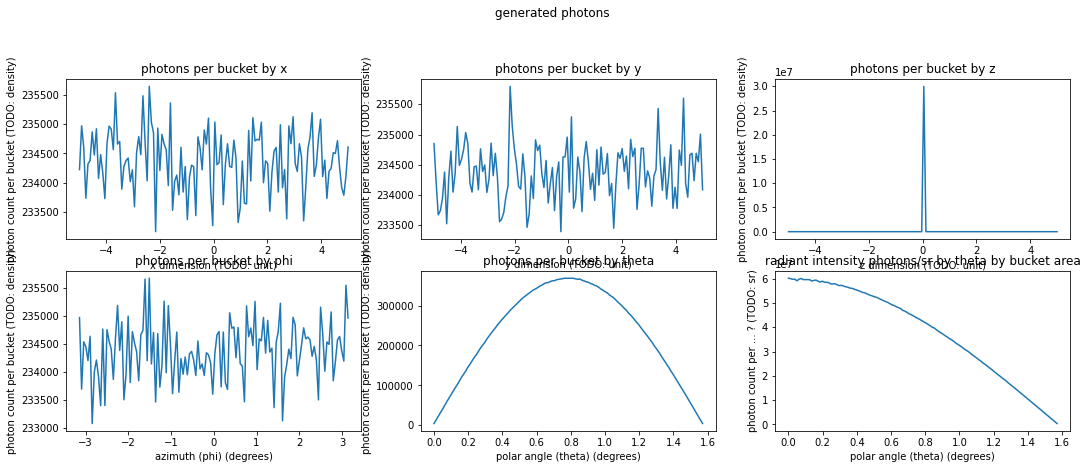

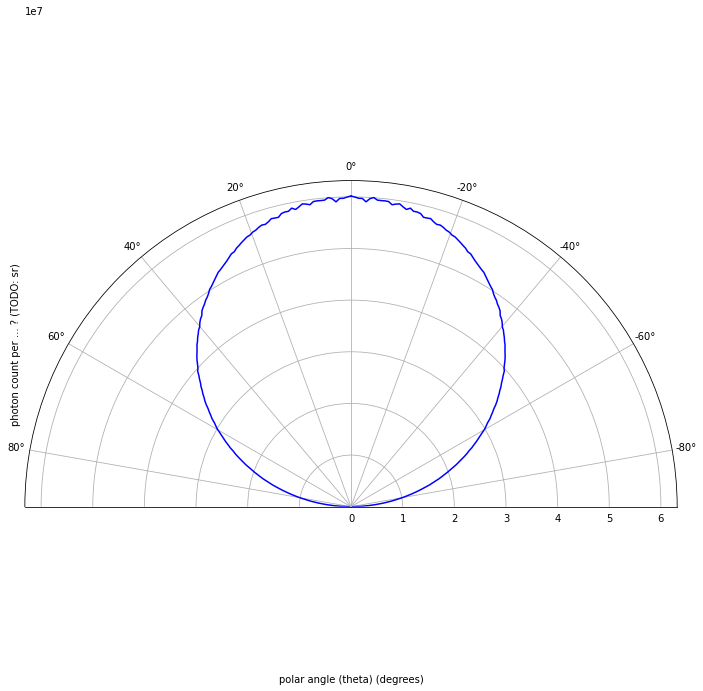

In [3]:
%%time
""" Look at the distributions of the generated photons."""
plot_histogram_slices(photons, "generated photons",
                      x_min = -source_size/2, x_max = source_size/2,
                      y_min = -source_size/2, y_max = source_size/2,
                      z_min = -5, z_max = 5,
                      theta_max = np.pi/2)

In [4]:
%%time
source_sample = photons.sample()

CPU times: user 0 ns, sys: 3.17 ms, total: 3.17 ms
Wall time: 6.29 ms


In [5]:
%%time
"""Look at the photons in 3d."""
source_box = [-source_size/2, source_size/2, -source_size/2, source_size/2, 0]
plot_3d([source_sample], ray_lengths=[1], boxes=[source_box], labels=['LED'], colors=[0xffff00])

Output()

CPU times: user 33.9 ms, sys: 287 µs, total: 34.1 ms
Wall time: 63.4 ms


In [6]:
%%time
""" Propagate the photons to the diffuser.

Most arrive at the diffuser surface.
Some are absorbed by the imperfectly reflective lightbox.
A square profile (or undersquare) helps keep the intensity even at the top. 
"""
###
lightbox_height = 400
lightbox_size = 400
###

lightbox = Lightbox(height = lightbox_height, size = lightbox_size)
lightbox.propagate(photons)
print(f"diffuser incident photons: {photons.size()}")

diffuser incident photons: 25348566
CPU times: user 4.63 s, sys: 3.2 ms, total: 4.63 s
Wall time: 4.63 s


In [7]:
box_sample = photons.sample()

In [8]:
%%time
lightbox_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height]
plot_3d([source_sample, box_sample], ray_lengths=[100, 100],
        boxes=[source_box, lightbox_box], labels=['LED','lightbox'], colors=[0xffff00, 0x00ffff])

Output()

CPU times: user 36 ms, sys: 389 µs, total: 36.4 ms
Wall time: 31.4 ms


CPU times: user 94.3 ms, sys: 4.32 ms, total: 98.6 ms
Wall time: 99 ms


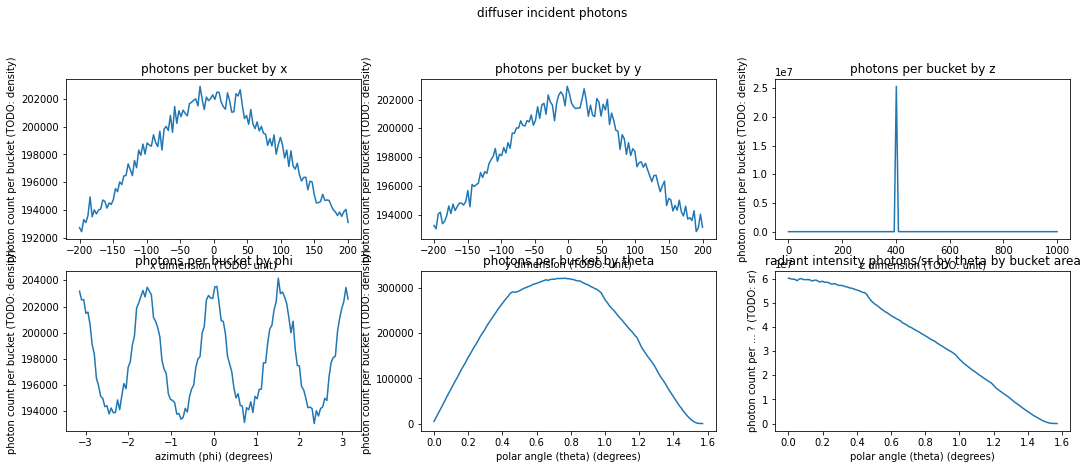

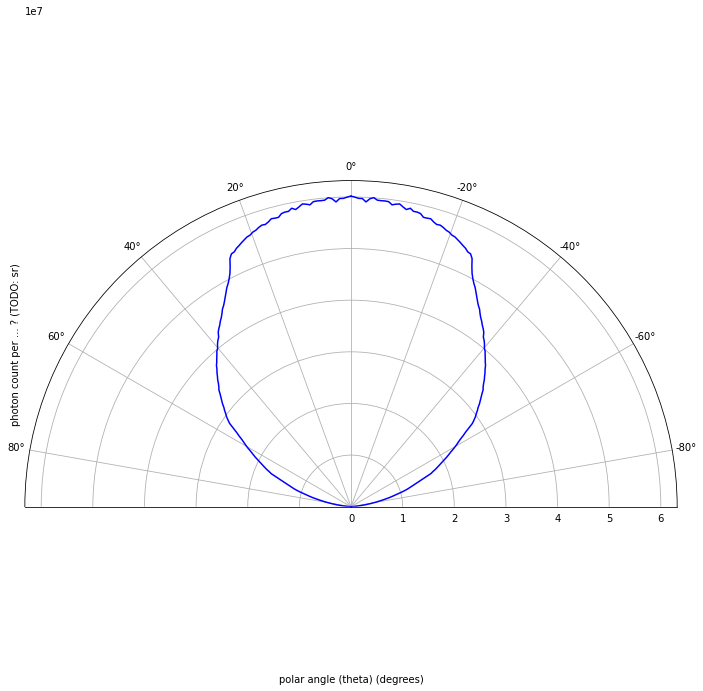

In [9]:
%%time
""" Show distributions of diffuser incident photons."""
plot_histogram_slices(photons, "diffuser incident photons",
                      x_min=-200, x_max=200,
                      y_min=-200, y_max=200,
                      z_min=0, z_max=1000, 
                      theta_max = np.pi/2)

In [10]:
%%time
""" Diffuse through the diffuser. """
diffuser = Diffuser(g = np.float32(0.64), absorption = np.float32(0.16))
diffuser.diffuse(photons)
print(f"diffuser-transmitted photons: {photons.size()}")

diffuser-transmitted photons: 21292243
CPU times: user 87.8 ms, sys: 7.41 ms, total: 95.2 ms
Wall time: 94.3 ms


CPU times: user 133 ms, sys: 856 µs, total: 133 ms
Wall time: 133 ms


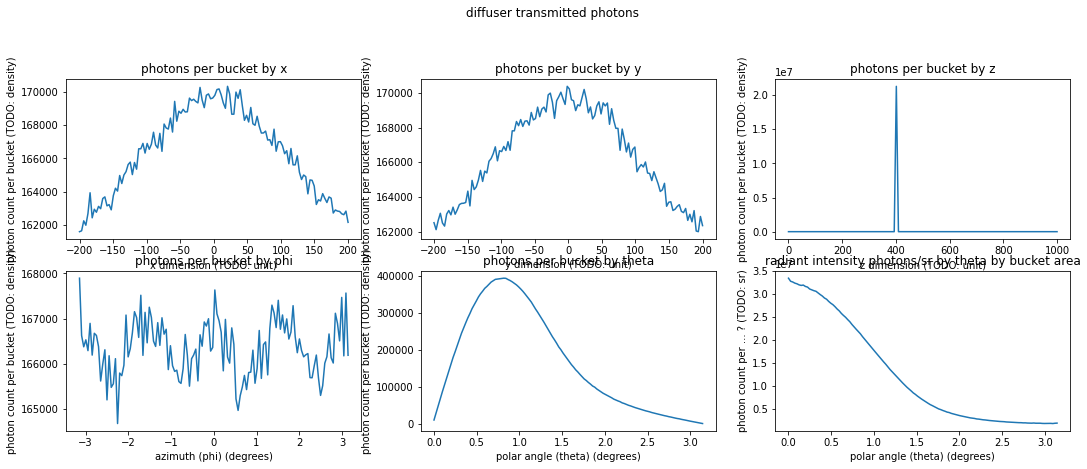

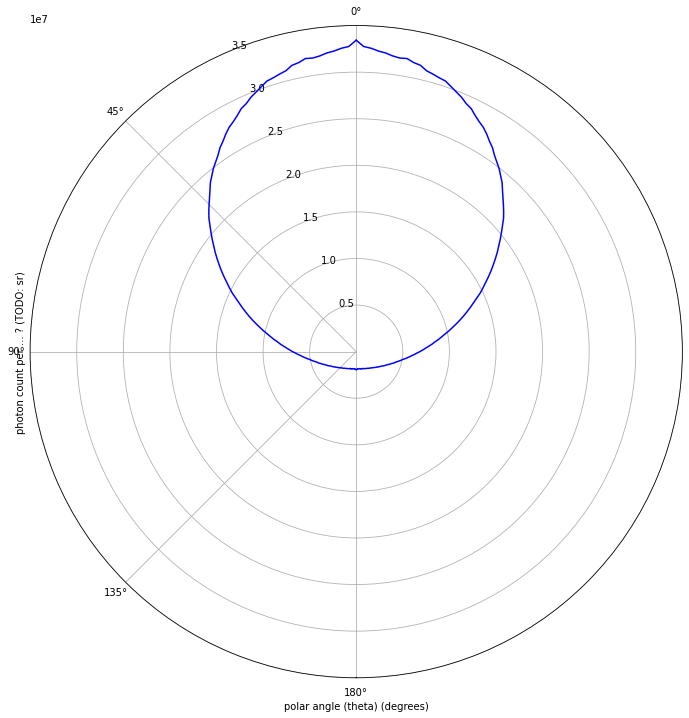

In [11]:
%%time
""" Show the distributions of photons transmitted by the diffuser.

Notice the distribution goes all the way to 180 degrees, a small fraction
of the incident photons are scattered downward.
"""
plot_histogram_slices(photons, "diffuser transmitted photons",
                      x_min=-200, x_max=200,
                      y_min=-200, y_max=200,
                      z_min=0, z_max=1000, 
                      theta_max = np.pi)

In [12]:
%%time
diff_sample = photons.sample()

CPU times: user 519 µs, sys: 33 µs, total: 552 µs
Wall time: 190 µs


In [13]:
%%time
""" Show the LED-produced and diffuser-transmitted photons in 3d. """
diff_box = [-lightbox_size/2, lightbox_size/2, -lightbox_size/2, lightbox_size/2, lightbox_height+1]
plot_3d([source_sample, box_sample, diff_sample],
        ray_lengths=[10, 10, 100],
        boxes=[source_box, lightbox_box, diff_box],
        labels=['LED', 'lightbox', 'diffuser'],
        colors=[0xffff00, 0x00ffff, 0xff00ff])

Output()

CPU times: user 75.8 ms, sys: 20.3 ms, total: 96.2 ms
Wall time: 40.5 ms


In [14]:
%%time
""" Propagate diffuser-transmitted photons to the (far away) reflector. """
# TODO: units.
# for now, unit is 100 microns, so
# min distance might be ... 10000 = 1 meter?  maybe less?
# max distance is probably ~100000 = 10 meters
# reflector size might be 10cm square (=1000)

reflector_distance = np.float32(100000)
#reflector_distance = np.float32(50000)
#reflector_distance = np.float32(10000)
propagate_to_reflector(photons, location = reflector_distance, size = np.float32(1000))
prune_outliers(photons, size = np.float32(1000))
print(f"reflector-incident photons: {photons.size()}")

reflector-incident photons: 506
CPU times: user 114 ms, sys: 55 µs, total: 114 ms
Wall time: 114 ms


CPU times: user 99.5 ms, sys: 183 µs, total: 99.7 ms
Wall time: 96.4 ms


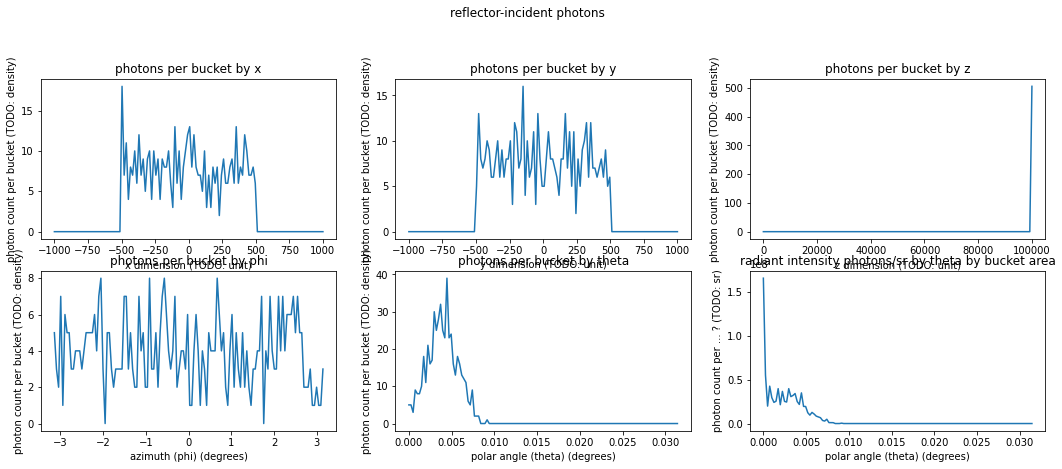

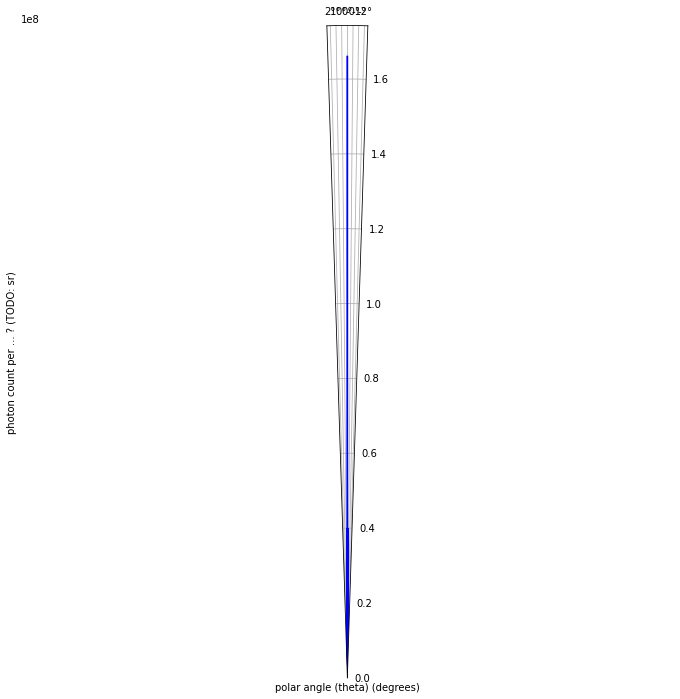

In [15]:
%%time
""" Show the distributions of reflector-incident photons """
plot_histogram_slices(photons, "reflector-incident photons",
                      x_min=-1000, x_max=1000,
                      y_min=-1000, y_max=1000,
                      z_min=0, z_max=reflector_distance,
                     theta_max = np.pi/100)

In [16]:
%%time
reflector_sample = photons.sample()

CPU times: user 998 µs, sys: 73 µs, total: 1.07 ms
Wall time: 335 µs


In [17]:
%%time
""" Show the generated, diffuser-transmitted, and reflector-incident photons in 3d. """
print(f"reflector-incident photons: {photons.size()}")
plot_3d([source_sample, box_sample, diff_sample],
        ray_lengths=[10, 10, 100],
        boxes=[source_box, lightbox_box, diff_box],
        labels=['LED', 'lightbox', 'diffuser'],
        colors=[0xffff00, 0x00ffff, 0xff00ff])
reflector_box = [-500, 500, -500, 500, reflector_distance]
plot_3d([reflector_sample],
        ray_lengths=[100],
        boxes=[reflector_box],
        labels=['reflector'],
        colors=[0x808000])

reflector-incident photons: 506


Output()

Output()

CPU times: user 95.6 ms, sys: 23.8 ms, total: 119 ms
Wall time: 63.5 ms


In [18]:
%%time
""" Reflect the incident photons at the reflector. """
print(f"reflector-incident photons: {photons.size()}")
# TODO: guess at absorption
reflector = Diffuser(g = np.float32(-0.9925), absorption=np.float32(0.0))
reflector.diffuse(photons)
print(f"reflected photons: {photons.size()}")

reflector-incident photons: 506
reflected photons: 506
CPU times: user 631 µs, sys: 0 ns, total: 631 µs
Wall time: 1.41 ms


CPU times: user 101 ms, sys: 45 µs, total: 101 ms
Wall time: 99.9 ms


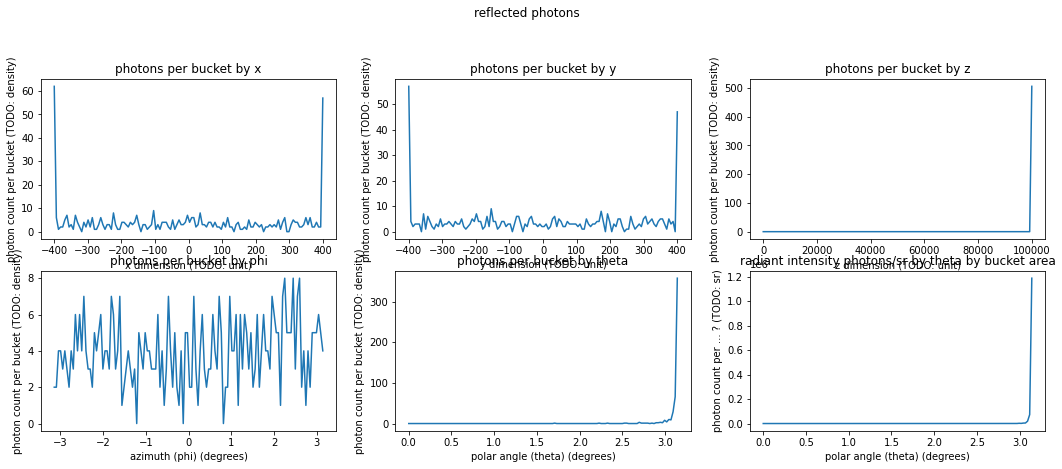

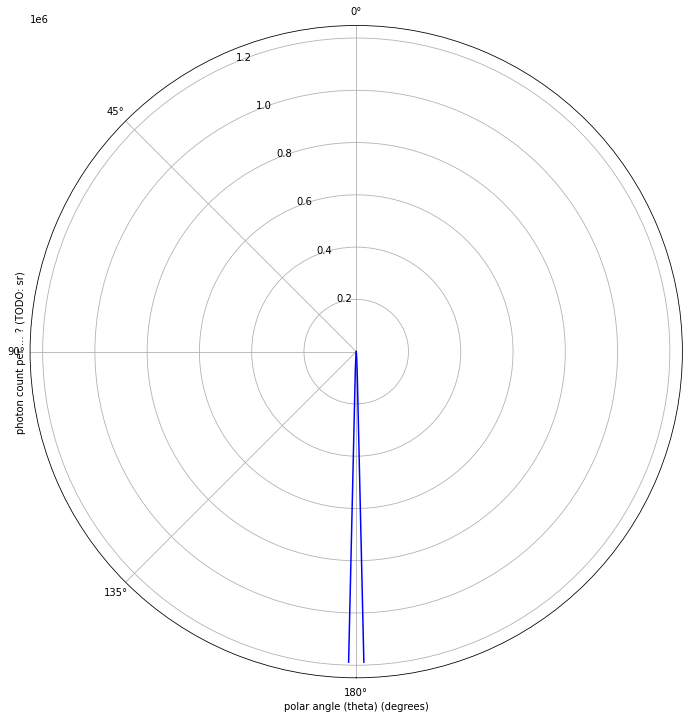

In [19]:
%%time
""" Show the distributions of reflected photons """
plot_histogram_slices(photons, "reflected photons", 
                      x_min=-400, x_max=400, 
                      y_min=-400, y_max=400, z_min=0,
                      z_max=reflector_distance)

In [20]:
%%time
reflected_sample = photons.sample()

CPU times: user 661 µs, sys: 0 ns, total: 661 µs
Wall time: 280 µs


In [21]:
%%time
""" Show the generated, transmitted, reflector-incident and reflected photons in 3d. """
reflected_box = [-500, 500, -500, 500, reflector_distance - 1]
plot_3d([reflector_sample, reflected_sample],
        ray_lengths=[100, 100],
        boxes=[reflector_box, reflected_box],
        labels=['reflector', 'reflected'],
        colors=[0x808000, 0x008080])

Output()

CPU times: user 115 ms, sys: 33.1 ms, total: 149 ms
Wall time: 98.3 ms


In [22]:
%%time
""" Propagate the reflected photons to the camera plane. """
print(f"reflected photons: {photons.size()}")
camera_distance = np.float32(lightbox_height) # make the camera height even with the diffuser
propagate_to_camera(photons, location = camera_distance)
prune_outliers(photons, size = np.float32(2000))
print(f"camera-incident photons: {photons.size()}")

reflected photons: 506
camera-incident photons: 241
CPU times: user 4.94 ms, sys: 0 ns, total: 4.94 ms
Wall time: 5.05 ms


CPU times: user 105 ms, sys: 0 ns, total: 105 ms
Wall time: 110 ms


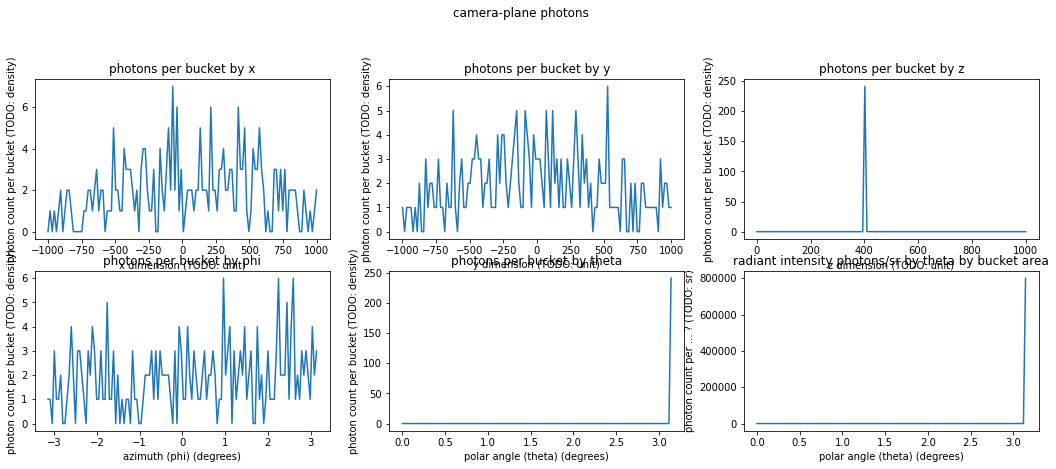

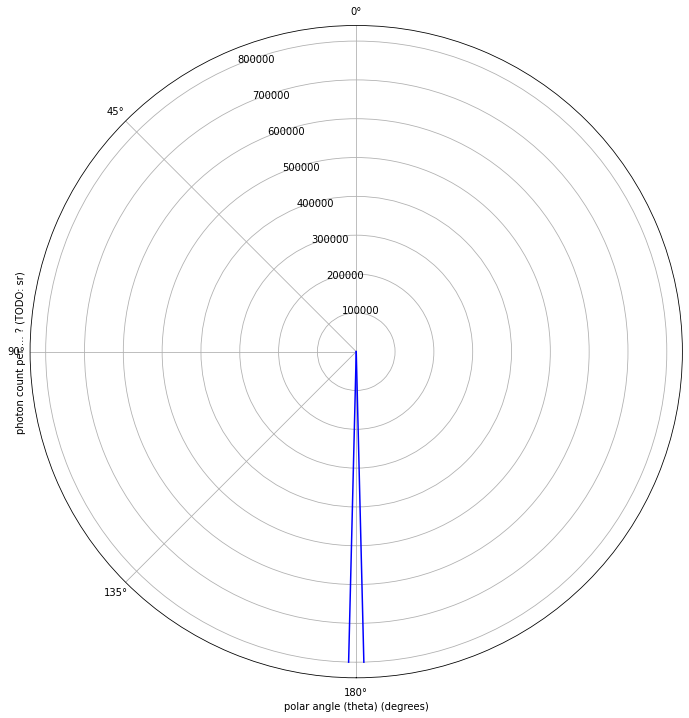

In [23]:
%%time
""" Show the distributions of camera-plane photons """
plot_histogram_slices(photons, "camera-plane photons",
                      x_min=-1000, x_max=1000,
                      y_min=-1000, y_max=1000,
                      z_min=0, z_max=1000)

In [24]:
%%time
camera_sample = photons.sample()

CPU times: user 1.13 ms, sys: 104 µs, total: 1.23 ms
Wall time: 356 µs


In [25]:
%%time
""" Show the reflected photons in 3d."""
# lightbox is -200,200, camera is 1cm so -50,50 but offset to the side.
camera_box = [200, 300, -50, 50, lightbox_height]
plot_3d([camera_sample],
        ray_lengths=[100],
        boxes=[diff_box, camera_box],
        labels=['diffuser','camera'],
        colors=[0x00ff00, 0xff00ff])

Output()

CPU times: user 53.5 ms, sys: 17.4 ms, total: 70.9 ms
Wall time: 30.2 ms
